In [1]:
import joblib
import pandas as pd
import numpy as np
import logging

FORMAT = "%(asctime)s %(message)s"
logging.basicConfig(level="INFO", format=FORMAT, datefmt="%d-%b-%y %H:%M:%S")


def load_data():
    try:
        path = "/Users/edeno/Downloads/"
        position_info = pd.read_pickle(path + "Jaq_03_16_position_info.pkl")
        spikes = pd.read_pickle(path + "Jaq_03_16_spikes.pkl")
        is_ripple = pd.read_pickle(path + "Jaq_03_16_is_ripple.pkl")
        env = joblib.load(path + "Jaq_03_16_environment.pkl")

        time = np.asarray(position_info.index / np.timedelta64(1, "s"))
        spikes = np.asarray(spikes).astype(float)
        spikes = (spikes > 0).astype(int)
        spike_times = [time[spike.astype(bool)] for spike in spikes.T]
        position = np.asarray(position_info.linear_position).astype(float)
        position2D = np.asarray(position_info[["nose_x", "nose_y"]]).astype(float)
        is_ripple = np.asarray(is_ripple).squeeze()
        speed = np.asarray(position_info.nose_vel).astype(float)
    except FileNotFoundError:
        path = "/cumulus/edeno/non_local_paper/notebooks/"
        position_info = pd.read_pickle(path + "Jaq_03_16_position_info.pkl")
        spikes = pd.read_pickle(path + "Jaq_03_16_spikes.pkl")
        spikes = (spikes > 0).astype(int)
        spike_times = [time[spike.astype(bool)] for spike in spikes.T]
        is_ripple = pd.read_pickle(path + "Jaq_03_16_is_ripple.pkl")
        env = joblib.load(path + "Jaq_03_16_environment.pkl")

        time = np.asarray(position_info.index / np.timedelta64(1, "s"))
        spikes = np.asarray(spikes).astype(float)
        position = np.asarray(position_info.linear_position).astype(float)
        position2D = np.asarray(position_info[["nose_x", "nose_y"]]).astype(float)
        is_ripple = np.asarray(is_ripple).squeeze()
        speed = np.asarray(position_info.nose_vel).astype(float)

    return is_ripple, spikes, position, speed, env, time, position2D

In [2]:
is_ripple, spikes, position, speed, env, time, position2D = load_data()
spikes = (spikes > 0).astype(int)
spike_times = [time[spike.astype(bool)] for spike in spikes.T]


sampling_frequency = 500
time_range = (time[0], time[-1] + (1 / sampling_frequency))

n_time_bins = int((time_range[-1] - time_range[0]) * sampling_frequency) + 1
t = time_range[0] + np.arange(n_time_bins) / sampling_frequency

np.allclose(t, time)

24-Jun-25 16:37:39 Cupy is not installed or GPU is not detected. Ignore this message if not using GPU
/Users/edeno/miniconda3/envs/non_local_detector2/lib/python3.12/site-packages/replay_trajectory_classification/likelihoods/multiunit_likelihood.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


True

In [3]:
from non_local_detector import NonLocalSortedSpikesDetector

detector = NonLocalSortedSpikesDetector(
    environments=env,
    sorted_spikes_algorithm="sorted_spikes_kde",
    sorted_spikes_algorithm_params={
        "position_std": np.sqrt(12.5),
        "block_size": int(2**12),
    },
).fit(time, position2D, spike_times, is_training=~is_ripple)

24-Jun-25 16:37:45 Fitting initial conditions...
24-Jun-25 16:37:45 Fitting discrete state transition
24-Jun-25 16:37:45 Fitting continuous state transition...
24-Jun-25 16:37:46 Fitting place fields...
24-Jun-25 16:37:48 Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
24-Jun-25 16:37:48 Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/edeno/miniconda3/envs/non_local_detector2/lib/python3.12/site-packages/jaxlib/../../../libtpu.so' (no such file), '/Users/edeno/miniconda3/envs/non_local_detector2/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


Encoding models:   0%|          | 0/104 [00:00<?, ?cell/s]

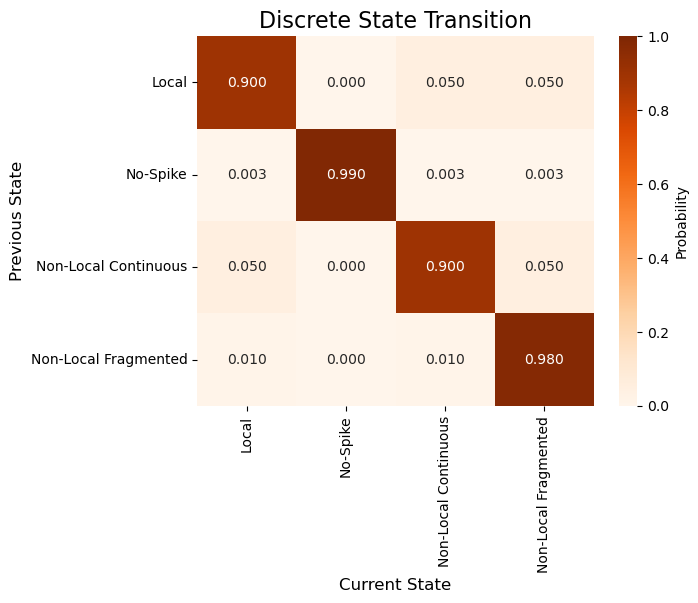

In [4]:
detector.plot_discrete_state_transition()

In [5]:
results = detector.predict(spike_times, time, position2D, time)
results

24-Jun-25 16:38:20 Computing posterior...
24-Jun-25 16:38:20 Computing log likelihood...


Local Likelihood:   0%|          | 0/104 [00:00<?, ?cell/s]

No Spike Likelihood:   0%|          | 0/104 [00:00<?, ?cell/s]

Non-Local Likelihood:   0%|          | 0/104 [00:00<?, ?cell/s]

/Users/edeno/Documents/GitHub/non_local_detector/src/non_local_detector/models/base.py:1222: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'state_bins' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  results = xr.Dataset(


<xarray.Dataset> Size: 742MB
Dimensions:                      (time: 452325, state_bins: 404, states: 4,
                                  state_ind: 404)
Coordinates:
  * time                         (time) float64 4MB 2.239e+04 ... 2.329e+04
  * state_bins                   (state_bins) object 3kB MultiIndex
  * state                        (state_bins) object 3kB 'Local' ... 'Non-Loc...
  * position                     (state_bins) float64 3kB nan nan ... 422.7
  * state_ind                    (state_ind) int64 3kB 0 1 2 2 2 2 ... 3 3 3 3 3
  * states                       (states) <U20 320B 'Local' ... 'Non-Local Fr...
    environments                 (states) <U1 16B '' '' '' ''
    encoding_groups              (states) int64 32B 0 0 0 0
Data variables:
    acausal_posterior            (time, state_bins) float32 731MB 1.0 ... 0.0...
    acausal_state_probabilities  (time, states) float32 7MB 1.0 ... 0.3985
Attributes:
    marginal_log_likelihoods:  -1917169.9

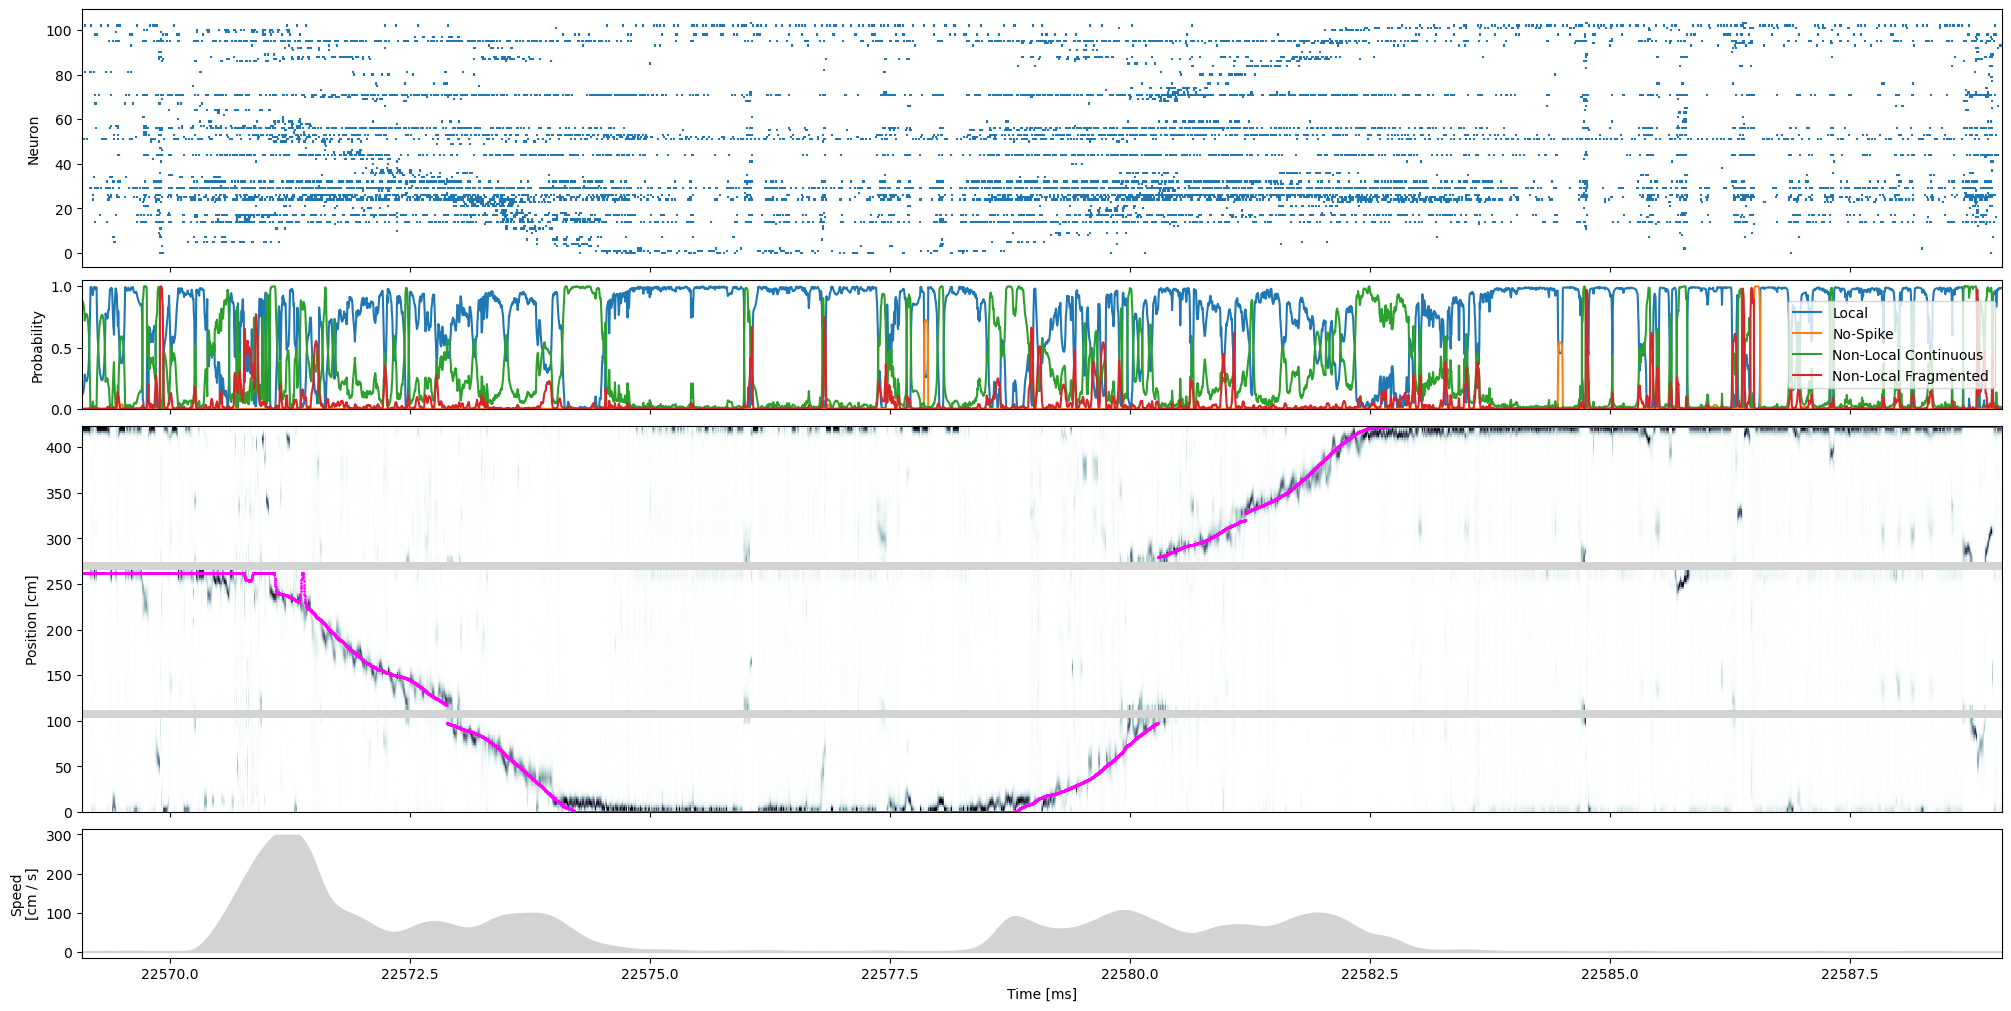

In [6]:
from non_local_detector.visualization import plot_non_local_model

plot_non_local_model(
    time,
    position,
    spike_times,
    speed,
    detector,
    results,
    time_slice=slice(time[90_000], time[100_000]),
    figsize=(20, 10),
)

In [ ]:
from non_local_detector import NonLocalSortedSpikesDetector


detector = NonLocalSortedSpikesDetector(
    environments=env,
    sorted_spikes_algorithm="sorted_spikes_kde",
    sorted_spikes_algorithm_params={
        "position_std": np.sqrt(12.5),
        "block_size": int(2**12),
    },
)
detector.estimate_parameters(
    time=time[:100],
    position_time=time[:100],
    position=position2D[:100],
    spike_times=spike_times,
    is_training=~is_ripple[:100],
)

In [ ]:
%debug